#Task 2-Experimentation and Uplift testing

Julia has asked us to evaluate the performance of a store trial which was performed in stores 77, 86 and 88.

This can be broken down by:

1. total sales revenue
2. total number of customers
3. average number of transactions per customer

Create a measure to compare different control stores to each of the trial stores to do this write a function to reduce having to re-do the analysis for each trial store. Consider using Pearson correlations or a metric such as a magnitude distance e.g. 1- (Observed distance – minimum distance)/(Maximum distance – minimum distance) as a measure.

Once you have selected your control stores, compare each trial and control pair during the trial period. You want to test if total sales are significantly different in the trial period and if so, check if the driver of change is more purchasing customers or more purchases per customers etc.

Main areas of Focus are :
1. Select control stores – Explore data, define metrics, visualize graphs
2. Assessment of the trial – insights/trends by comparing trial stores with control stores
3. Collate findings – summarize and provide recommendations


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
qvi = pd.read_csv("/content/QVI_data.csv")
qvi.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


**Checking for nulls**

In [3]:
qvi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [4]:
qvi["DATE"] = pd.to_datetime(qvi["DATE"])
qvi["YEARMONTH"] = qvi["DATE"].dt.strftime("%Y%m").astype("int")

Compile each store's monthly:

1. Total sales
2. Number of customers,
3. Average transactions per customer
4. Average chips per customer
5. Average price per unit

In [5]:
def monthly_store_metrics():
    store_yrmo_group = qvi.groupby(["STORE_NBR", "YEARMONTH"])
    total = store_yrmo_group["TOT_SALES"].sum()
    num_cust = store_yrmo_group["LYLTY_CARD_NBR"].nunique()
    trans_per_cust = store_yrmo_group.size() / num_cust
    avg_chips_per_cust = store_yrmo_group["PROD_QTY"].sum() / num_cust
    avg_chips_price = total / store_yrmo_group["PROD_QTY"].sum()
    aggregates = [total, num_cust, trans_per_cust, avg_chips_per_cust, avg_chips_price]
    metrics = pd.concat(aggregates, axis=1)
    metrics.columns = ["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"]
    return metrics

In [6]:
qvi_monthly_metrics = monthly_store_metrics().reset_index()
qvi_monthly_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STORE_NBR        3169 non-null   int64  
 1   YEARMONTH        3169 non-null   int64  
 2   TOT_SALES        3169 non-null   float64
 3   nCustomers       3169 non-null   int64  
 4   nTxnPerCust      3169 non-null   float64
 5   nChipsPerTxn     3169 non-null   float64
 6   avgPricePerUnit  3169 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 173.4 KB


**Pre-Trial Observation as this filter only stores with full 12 months observation**

In [7]:
observ_counts = qvi_monthly_metrics["STORE_NBR"].value_counts()
full_observ_index = observ_counts[observ_counts == 12].index
full_observ = qvi_monthly_metrics[qvi_monthly_metrics["STORE_NBR"].isin(full_observ_index)]
pretrial_full_observ = full_observ[full_observ["YEARMONTH"] < 201902]

pretrial_full_observ.head(8)

,STORE_NBR,YEARMONTH,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.265306,3.337097
1,1,201808,176.1,42,1.023810,1.285714,3.261111
2,1,201809,278.8,59,1.050847,1.271186,3.717333
3,1,201810,188.1,44,1.022727,1.318182,3.243103
4,1,201811,192.6,46,1.021739,1.239130,3.378947
5,1,201812,189.6,42,1.119048,1.357143,3.326316
6,1,201901,154.8,35,1.028571,1.200000,3.685714
12,2,201807,150.8,39,1.051282,1.179487,3.278261


In [11]:
def calcCorrTable(metricCol, storeComparison, inputTable=pretrial_full_observ):
  control_store_nbrs = inputTable[~inputTable["STORE_NBR"].isin([77, 86, 88])]["STORE_NBR"].unique()
  corrs = pd.DataFrame(columns = ["YEARMONTH", "Trial_Str", "Ctrl_Str", "Corr_Score"])
  trial_store = inputTable[inputTable["STORE_NBR"] == storeComparison][metricCol].reset_index()
  for control in control_store_nbrs:
    concat_df = pd.DataFrame(columns = ["YEARMONTH", "Trial_Str", "Ctrl_Str", "Corr_Score"])
    control_store = inputTable[inputTable["STORE_NBR"] == control][metricCol].reset_index()
    concat_df["Corr_Score"] = trial_store.corrwith(control_store, axis=1)
    concat_df["Trial_Str"] = storeComparison
    concat_df["Ctrl_Str"] = control
    concat_df["YEARMONTH"] = list(inputTable[inputTable["STORE_NBR"] == storeComparison]["YEARMONTH"])
    corrs = pd.concat([corrs, concat_df])
  return corrs

In [12]:
corr_table = pd.DataFrame()
for trial_num in [77, 86, 88]:
    corr_table = pd.concat([corr_table, calcCorrTable(["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"], trial_num)])
    
corr_table.head(8)

,YEARMONTH,Trial_Str,Ctrl_Str,Corr_Score
0,201807,77,1,0.070414
1,201808,77,1,0.027276
2,201809,77,1,0.002389
3,201810,77,1,-0.020045
4,201811,77,1,0.030024
5,201812,77,1,0.063946
6,201901,77,1,0.001470
0,201807,77,2,0.142957


In [13]:
def calculateMagnitudeDistance(metricCol, storeComparison, inputTable=pretrial_full_observ):
    control_store_nbrs = inputTable[~inputTable["STORE_NBR"].isin([77, 86, 88])]["STORE_NBR"].unique()
    dists = pd.DataFrame()
    trial_store = inputTable[inputTable["STORE_NBR"] == storeComparison][metricCol]
    for control in control_store_nbrs:
        concat_df  = abs(inputTable[inputTable["STORE_NBR"] == storeComparison].reset_index()[metricCol] - inputTable[inputTable["STORE_NBR"] == control].reset_index()[metricCol])
        concat_df["YEARMONTH"] = list(inputTable[inputTable["STORE_NBR"] == storeComparison]["YEARMONTH"])
        concat_df["Trial_Str"] = storeComparison
        concat_df["Ctrl_Str"] = control
        dists = pd.concat([dists, concat_df])
    for col in metricCol:
        dists[col] = 1 - ((dists[col] - dists[col].min()) / (dists[col].max() - dists[col].min()))
    dists["magnitude"] = dists[metricCol].mean(axis=1)
    return dists

In [14]:
dist_table = pd.DataFrame()
for trial_num in [77, 86, 88]:
    dist_table = pd.concat([dist_table, calculateMagnitudeDistance(["TOT_SALES", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"], trial_num)])
    
dist_table.head(8)
dist_table

,TOT_SALES,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,YEARMONTH,Trial_Str,Ctrl_Str,magnitude
0,0.935431,0.980769,0.958035,0.739412,0.883569,201807,77,1,0.899443
1,0.942972,0.951923,0.993823,0.802894,0.886328,201808,77,1,0.915588
2,0.961503,0.836538,0.992126,0.730041,0.703027,201809,77,1,0.844647
3,0.988221,0.932692,0.989514,0.940460,0.590528,201810,77,1,0.888283
4,0.962149,0.951923,0.874566,0.730358,0.832481,201811,77,1,0.870296
...,...,...,...,...,...,...,...,...,...
2,0.207554,0.286822,0.462846,0.779879,0.923887,201809,88,272,0.532198
3,0.346797,0.387597,0.571497,0.796875,0.971133,201810,88,272,0.614780
4,0.286706,0.310078,0.623883,0.813241,0.966999,201811,88,272,0.600181
5,0.347151,0.387597,0.376456,0.699748,0.962198,201812,88,272,0.554630


We'll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores by using correlation and magnitude distance.

In [15]:
def combine_corr_dist(metricCol, storeComparison, inputTable=pretrial_full_observ):
    corrs = calcCorrTable(metricCol, storeComparison, inputTable)
    dists = calculateMagnitudeDistance(metricCol, storeComparison, inputTable)
    dists = dists.drop(metricCol, axis=1)
    combine = pd.merge(corrs, dists, on=["YEARMONTH", "Trial_Str", "Ctrl_Str"])
    return combine

In [16]:
compare_metrics_table1 = pd.DataFrame()
for trial_num in [77, 86, 88]:
    compare_metrics_table1 = pd.concat([compare_metrics_table1, combine_corr_dist(["TOT_SALES"], trial_num)])

In [17]:
corr_weight = 0.5
dist_weight = 1 - corr_weight

Determining the top five highest composite score for each trial based on Total sales

In [18]:
grouped_comparison_table1 = compare_metrics_table1.groupby(["Trial_Str", "Ctrl_Str"]).mean().reset_index()
grouped_comparison_table1["CompScore"] = (corr_weight * grouped_comparison_table1["Corr_Score"]) + (dist_weight * grouped_comparison_table1["magnitude"])
for trial_num in compare_metrics_table1["Trial_Str"].unique():
    print(grouped_comparison_table1[grouped_comparison_table1["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").head(), '\n')

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
218         77       233         1.0   0.986477   0.993238
239         77       255         1.0   0.979479   0.989739
177         77       188         1.0   0.977663   0.988831
49          77        53         1.0   0.976678   0.988339
120         77       131         1.0   0.976267   0.988134 

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
356         86       109         1.0   0.966783   0.983391
401         86       155         1.0   0.965876   0.982938
464         86       222         1.0   0.962280   0.981140
467         86       225         1.0   0.960512   0.980256
471         86       229         1.0   0.951704   0.975852 

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
551         88        40         1.0   0.941165   0.970582
538         88        26         1.0   0.904377   0.952189
582         88        72         1.0   0.903800   0.951900
517         88         4         1.0   0.903466   0.

In [19]:
compare_metrics_table2 = pd.DataFrame()
for trial_num in [77, 86, 88]:
    compare_metrics_table2 = pd.concat([compare_metrics_table2, combine_corr_dist(["nCustomers"], trial_num)])

Determining the top five highest composite score for each trial based on no. of customers

In [20]:
grouped_comparison_table2 = compare_metrics_table2.groupby(["Trial_Str", "Ctrl_Str"]).mean().reset_index()
grouped_comparison_table2["CompScore"] = (corr_weight * grouped_comparison_table2["Corr_Score"]) + (dist_weight * grouped_comparison_table2["magnitude"])
for trial_num in compare_metrics_table2["Trial_Str"].unique():
    print(grouped_comparison_table2[grouped_comparison_table2["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").head(), '\n')

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
218         77       233         1.0   0.993132   0.996566
38          77        41         1.0   0.976648   0.988324
101         77       111         1.0   0.968407   0.984203
105         77       115         1.0   0.967033   0.983516
15          77        17         1.0   0.965659   0.982830 

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
401         86       155         1.0   0.986772   0.993386
467         86       225         1.0   0.969577   0.984788
356         86       109         1.0   0.969577   0.984788
471         86       229         1.0   0.964286   0.982143
293         86        39         1.0   0.961640   0.980820 

     Trial_Str  Ctrl_Str  Corr_Score  magnitude  CompScore
736         88       237         1.0   0.987818   0.993909
705         88       203         1.0   0.944629   0.972315
551         88        40         1.0   0.942414   0.971207
668         88       165         1.0   0.935770   0.

In [21]:
for trial_num in compare_metrics_table2["Trial_Str"].unique():
    a = grouped_comparison_table1[grouped_comparison_table1["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").set_index(["Trial_Str", "Ctrl_Str"])["CompScore"]
    b = grouped_comparison_table2[grouped_comparison_table2["Trial_Str"] == trial_num].sort_values(ascending=False, by="CompScore").set_index(["Trial_Str", "Ctrl_Str"])["CompScore"]
    print((pd.concat([a,b], axis=1).sum(axis=1)/2).sort_values(ascending=False).head(3), '\n')

Trial_Str  Ctrl_Str
77         233         0.994902
           41          0.986020
           46          0.984762
dtype: float64 

Trial_Str  Ctrl_Str
86         155         0.988162
           109         0.984090
           225         0.982522
dtype: float64 

Trial_Str  Ctrl_Str
88         40          0.970895
           26          0.958929
           72          0.954079
dtype: float64 



Similarities based on total sales:
1. Trial store 77: Store 233, 255, 188
2. Trial store 86: Store 109, 155, 222
3. Trial store 88: Store 40, 26, 72

Similarities based on No. of Customers:
1. Trial store 77: Store 233, 41, 111
2. Trial store 86: Store 155, 225, 109
3. Trial store 88: Store 237, 203, 40

Final SImilarities based on Highest average of both features combined:
1. Trial store 77: Store 233
2. Trial store 86: Store 155
3. Trial store 88: Store 40


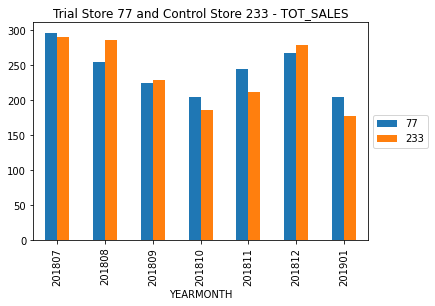

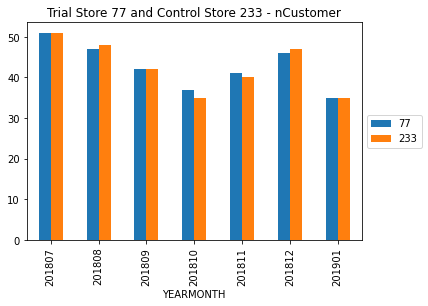

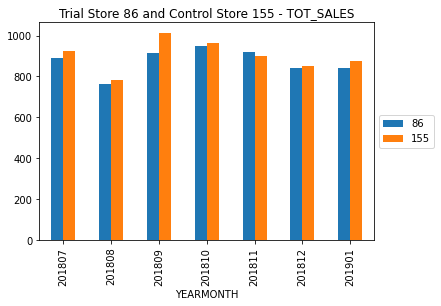

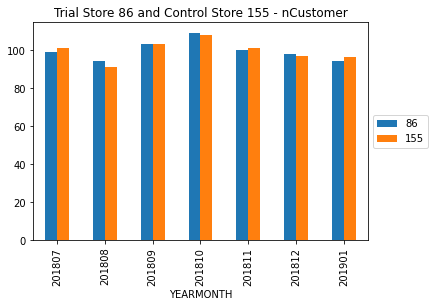

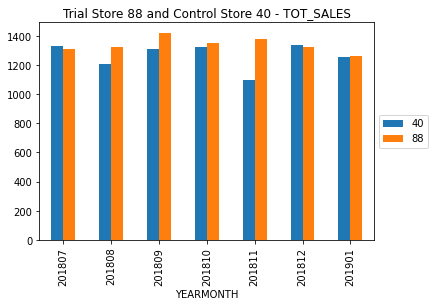

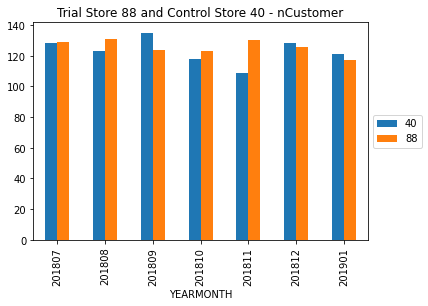

In [22]:
trial_control_dic = {77:233, 86:155, 88:40}
for key, val in trial_control_dic.items():
    pretrial_full_observ[pretrial_full_observ["STORE_NBR"].isin([key, val])].groupby(
        ["YEARMONTH", "STORE_NBR"]).sum()["TOT_SALES"].unstack().plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(key)+" and Control Store "+str(val)+" - TOT_SALES")
    plt.show()
    pretrial_full_observ[pretrial_full_observ["STORE_NBR"].isin([key, val])].groupby(
    ["YEARMONTH", "STORE_NBR"]).sum()["nCustomers"].unstack().plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(key)+" and Control Store "+str(val)+" - nCustomer")
    plt.show()
    print('\n')

Next we'll compare the performance of Trial stores to Control stores during the trial period. To ensure their performance is comparable during Trial period, we need to scale (multiply to ratio of trial / control) all of Control stores' performance to Trial store's performance during pre-trial. Starting with TOT_SALES.

In [23]:
#Ratio of Store 77 and its Control store.
sales_ratio_77 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 77]["TOT_SALES"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 233]["TOT_SALES"].sum()

#Ratio of Store 86 and its Control store.
sales_ratio_86 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 86]["TOT_SALES"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 155]["TOT_SALES"].sum()

#Ratio of Store 77 and its Control store.
sales_ratio_88 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 88]["TOT_SALES"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 40]["TOT_SALES"].sum()

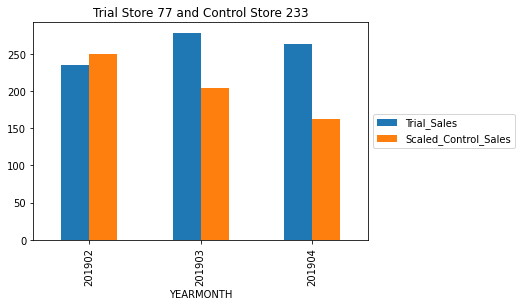

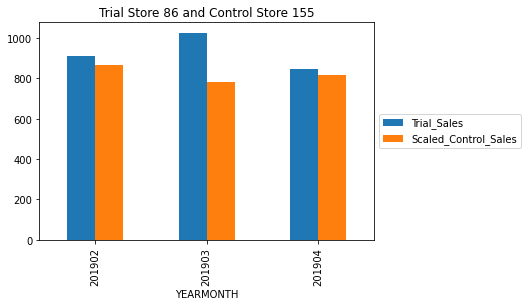

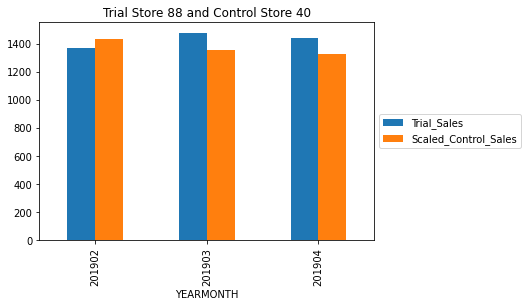

In [25]:
trial_full_observ = full_observ[(full_observ["YEARMONTH"] >= 201902) & (full_observ["YEARMONTH"] <= 201904)]
scaled_sales_control_stores = full_observ[full_observ["STORE_NBR"].isin([233, 155, 40])][["STORE_NBR", "YEARMONTH", "TOT_SALES"]]

def scaler(row):
    if row["STORE_NBR"] == 233:
        return row["TOT_SALES"] * sales_ratio_77
    elif row["STORE_NBR"] == 155:
        return row["TOT_SALES"] * sales_ratio_86
    elif row["STORE_NBR"] == 40:
        return row["TOT_SALES"] * sales_ratio_88

scaled_sales_control_stores["ScaledSales"] = scaled_sales_control_stores.apply(lambda row: scaler(row), axis=1)

trial_scaled_sales_control_stores = scaled_sales_control_stores[(scaled_sales_control_stores["YEARMONTH"] >= 201902) & (scaled_sales_control_stores["YEARMONTH"] <= 201904)]
pretrial_scaled_sales_control_stores = scaled_sales_control_stores[scaled_sales_control_stores["YEARMONTH"] < 201902]

percentage_diff = {}

for trial, control in trial_control_dic.items():
    a = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == control]
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "TOT_SALES"]]
    percentage_diff[trial] = b["TOT_SALES"].sum() / a["ScaledSales"].sum()
    b[["YEARMONTH", "TOT_SALES"]].merge(a[["YEARMONTH", "ScaledSales"]],on="YEARMONTH").set_index("YEARMONTH").rename(columns={"ScaledSales":"Scaled_Control_Sales", "TOT_SALES":"Trial_Sales"}).plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control))

In [26]:
percentage_diff

{77: 1.2615468650086274, 86: 1.13150143573637, 88: 1.0434583458542188}

In [27]:
temp1 = scaled_sales_control_stores.sort_values(by=["STORE_NBR", "YEARMONTH"], ascending=[False, True]).reset_index().drop(["TOT_SALES", "index"], axis=1)
temp2 = full_observ[full_observ["STORE_NBR"].isin([77,86,88])][["STORE_NBR", "YEARMONTH", "TOT_SALES"]].reset_index().drop(["index", "YEARMONTH"], axis=1)
scaledsales_vs_trial = pd.concat([temp1, temp2], axis=1)
scaledsales_vs_trial.columns = ["c_STORE_NBR", "YEARMONTH", "c_ScaledSales", "t_STORE_NBR", "t_TOT_SALES"]
scaledsales_vs_trial["Sales_Percentage_Diff"] = (scaledsales_vs_trial["t_TOT_SALES"] - scaledsales_vs_trial["c_ScaledSales"]) / (((scaledsales_vs_trial["t_TOT_SALES"] + scaledsales_vs_trial["c_ScaledSales"])/2))
def label_period(cell):
    if cell < 201902:
        return "pre"
    elif cell > 201904:
        return "post"
    else:
        return "trial"
scaledsales_vs_trial["trial_period"] = scaledsales_vs_trial["YEARMONTH"].apply(lambda cell: label_period(cell))
scaledsales_vs_trial[scaledsales_vs_trial["trial_period"] == "trial"]

,c_STORE_NBR,YEARMONTH,c_ScaledSales,t_STORE_NBR,t_TOT_SALES,Sales_Percentage_Diff,trial_period
7,233,201902,249.762622,77,235.0,-0.060907,trial
8,233,201903,203.802205,77,278.5,0.309755,trial
9,233,201904,162.345704,77,263.5,0.475075,trial
19,155,201902,864.522060,86,913.2,0.054764,trial
20,155,201903,780.320405,86,1026.8,0.272787,trial
21,155,201904,819.317024,86,848.2,0.034642,trial
31,40,201902,1434.399269,88,1370.2,-0.045781,trial
32,40,201903,1352.064709,88,1477.2,0.088458,trial
33,40,201904,1321.797762,88,1439.4,0.085182,trial


Check significance of Trial minus Control stores TOT_SALES Percentage Difference Pre-Trial vs Trial.

Step 1: Check null hypothesis of 0 difference between control store's Pre-Trial and Trial period performance.

Step 2: Proof control and trial stores are similar statistically

Check p-value of control store's Pre-Trial vs Trial store's Pre-Trial.
If <5%, it is significantly different. If >5%, it is not significantly different (similar).

Step 3: After checking Null Hypothesis of first 2 step to be true, we can check Null Hypothesis of Percentage Difference between Trial and Control stores during pre-trial is the same as during trial.

Check T-Value of Percentage Difference of each Trial month (Feb, March, April 2019).
Mean is mean of Percentage Difference during pre-trial.
Standard deviation is stdev of Percentage Difference during pre-trial.
Formula is Trial month's Percentage Difference minus Mean, divided by Standard deviation.
Compare each T-Value with 95% percentage significance critical t-value of 6 degrees of freedom (7 months of sample - 1)

In [28]:
from scipy.stats import ttest_ind, t

# Step 1
for num in [40, 155, 233]:
    print("Store", num)
    print(ttest_ind(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"],
                   trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"],
                   equal_var=False), '\n')
    #print(len(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"]), len(trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"]))
    
alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=min([len(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == num]),
                       len(trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == num])])-1))

Store 40
Ttest_indResult(statistic=-0.5958372343168585, pvalue=0.5722861621434009) 

Store 155
Ttest_indResult(statistic=1.429195687929098, pvalue=0.19727058651603258) 

Store 233
Ttest_indResult(statistic=1.1911026010974504, pvalue=0.29445006064862156) 

Critical t-value for 95% confidence interval:
[-4.30265273  4.30265273]


In [29]:

a = pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == 40]["ScaledSales"]
b = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == 40]["ScaledSales"]


Null hypothesis is true. There isn't any statistically significant difference between control store's scaled Pre-Trial and Trial period sales.

In [30]:
# Step 2
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    print(ttest_ind(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial]["TOT_SALES"],
                   pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == cont]["ScaledSales"],
                   equal_var=True), '\n')
    #print(len(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial]["TOT_SALES"]),len(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == cont]["ScaledSales"]))

alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=len(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial])-1))

Trial store: 77 , Control store: 233
Ttest_indResult(statistic=-1.2533353315065926e-15, pvalue=0.999999999999999) 

Trial store: 86 , Control store: 155
Ttest_indResult(statistic=0.0, pvalue=1.0) 

Trial store: 88 , Control store: 40
Ttest_indResult(statistic=0.0, pvalue=1.0) 

Critical t-value for 95% confidence interval:
[-2.44691185  2.44691185]


Null hypothesis is true. There isn't any statistically significant difference between Trial store's sales and Control store's scaled-sales performance during pre-trial.

In [31]:
# Step 3
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    temp_pre = scaledsales_vs_trial[(scaledsales_vs_trial["c_STORE_NBR"] == cont) & (scaledsales_vs_trial["trial_period"]=="pre")]
    std = temp_pre["Sales_Percentage_Diff"].std()
    mean = temp_pre["Sales_Percentage_Diff"].mean()
    #print(std, mean)
    for t_month in scaledsales_vs_trial[scaledsales_vs_trial["trial_period"] == "trial"]["YEARMONTH"].unique():
        pdif = scaledsales_vs_trial[(scaledsales_vs_trial["YEARMONTH"] == t_month) & (scaledsales_vs_trial["t_STORE_NBR"] == trial)]["Sales_Percentage_Diff"]
        print(t_month,":",(float(pdif)-mean)/std)
    print('\n')
    
print("Critical t-value for 95% confidence interval:")
conf_intv_95 = t.ppf(0.95, df=len(temp_pre)-1)
print(conf_intv_95)

Trial store: 77 , Control store: 233
201902 : -0.7171038288055888
201903 : 3.035317928855662
201904 : 4.708944418758203


Trial store: 86 , Control store: 155
201902 : 1.4133618775921797
201903 : 7.123063846042149
201904 : 0.8863824572944162


Trial store: 88 , Control store: 40
201902 : -0.5481633746817604
201903 : 1.0089992743637755
201904 : 0.9710006270463645


Critical t-value for 95% confidence interval:
1.9431802803927816



There are 3 months' increase in performance that are statistically significant (Above the 95% confidence interval t-score):

March and April trial months for trial store 77

March trial months for trial store 86

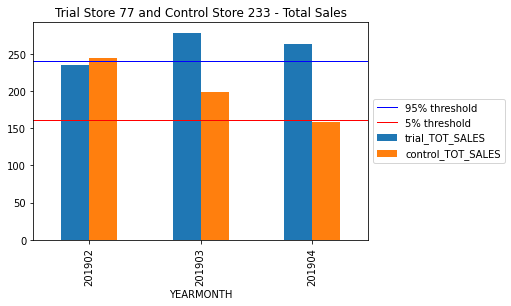

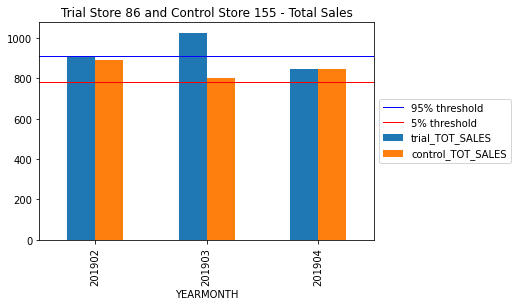

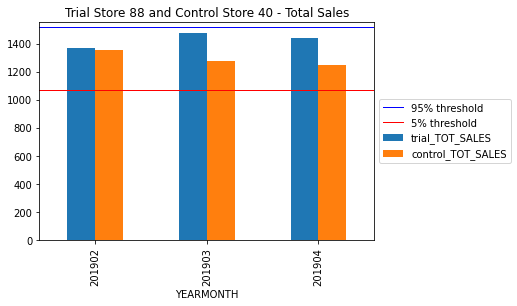

In [32]:
for trial, control in trial_control_dic.items():
    a = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == control].rename(columns={"TOT_SALES": "control_TOT_SALES"})
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "TOT_SALES"]].rename(columns={"TOT_SALES": "trial_TOT_SALES"})
    comb = b[["YEARMONTH", "trial_TOT_SALES"]].merge(a[["YEARMONTH", "control_TOT_SALES"]],on="YEARMONTH").set_index("YEARMONTH")
    comb.plot.bar()
    cont_sc_sales = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == control]["TOT_SALES"]
    std = scaledsales_vs_trial[(scaledsales_vs_trial["c_STORE_NBR"] == control) & (scaledsales_vs_trial["trial_period"]=="pre")]["Sales_Percentage_Diff"].std()
    thresh95 = cont_sc_sales.mean() + (cont_sc_sales.mean() * std * 2)
    thresh5 = cont_sc_sales.mean() - (cont_sc_sales.mean() * std * 2)
    plt.axhline(y=thresh95,linewidth=1, color='b', label="95% threshold")
    plt.axhline(y=thresh5,linewidth=1, color='r', label="5% threshold")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control)+" - Total Sales")
    plt.savefig("TS {} and CS {} - TOT_SALES.png".format(trial,control), bbox_inches="tight")

In [33]:
#Ratio of Store 77 and its Control store.
ncust_ratio_77 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 77]["nCustomers"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 233]["nCustomers"].sum()

#Ratio of Store 86 and its Control store.
ncust_ratio_86 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 86]["nCustomers"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 155]["nCustomers"].sum()

#Ratio of Store 77 and its Control store.
ncust_ratio_88 = pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 88]["nCustomers"].sum() / pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == 40]["nCustomers"].sum()

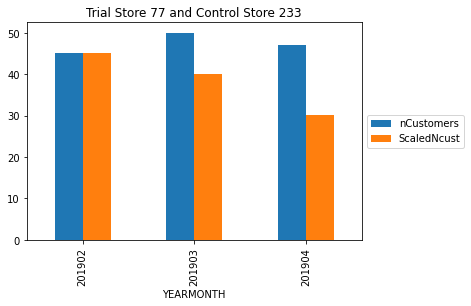

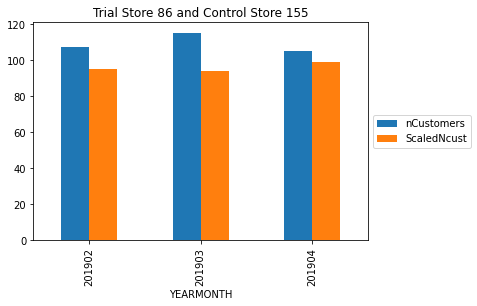

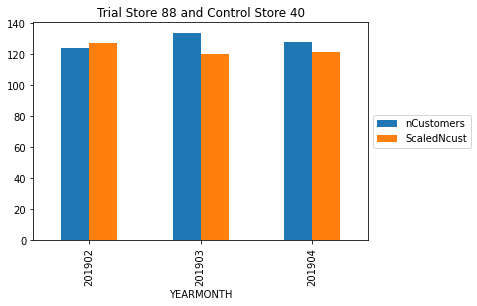

In [34]:
#trial_full_observ = full_observ[(full_observ["YEARMONTH"] >= 201902) & (full_observ["YEARMONTH"] <= 201904)]
scaled_ncust_control_stores = full_observ[full_observ["STORE_NBR"].isin([233, 155, 40])][["STORE_NBR", "YEARMONTH", "nCustomers"]]

def scaler_c(row):
    if row["STORE_NBR"] == 233:
        return row["nCustomers"] * ncust_ratio_77
    elif row["STORE_NBR"] == 155:
        return row["nCustomers"] * ncust_ratio_86
    elif row["STORE_NBR"] == 40:
        return row["nCustomers"] * ncust_ratio_88

scaled_ncust_control_stores["ScaledNcust"] = scaled_ncust_control_stores.apply(lambda row: scaler_c(row), axis=1)

trial_scaled_ncust_control_stores = scaled_ncust_control_stores[(scaled_ncust_control_stores["YEARMONTH"] >= 201902) & (scaled_ncust_control_stores["YEARMONTH"] <= 201904)]
pretrial_scaled_ncust_control_stores = scaled_ncust_control_stores[scaled_ncust_control_stores["YEARMONTH"] < 201902]

ncust_percentage_diff = {}

for trial, control in trial_control_dic.items():
    a = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control]
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "nCustomers"]]
    ncust_percentage_diff[trial] = b["nCustomers"].sum() / a["ScaledNcust"].sum()
    b[["YEARMONTH", "nCustomers"]].merge(a[["YEARMONTH", "ScaledNcust"]],on="YEARMONTH").set_index("YEARMONTH").rename(columns={"ScaledSales":"Scaled_Control_nCust", "TOT_SALES":"Trial_nCust"}).plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control))

In [35]:
ncust_percentage_diff

{77: 1.2306529009742622, 86: 1.1354166666666667, 88: 1.0444876946258161}

In [36]:
temp1 = scaled_ncust_control_stores.sort_values(by=["STORE_NBR", "YEARMONTH"], ascending=[False, True]).reset_index().drop(["nCustomers", "index"], axis=1)
temp2 = full_observ[full_observ["STORE_NBR"].isin([77,86,88])][["STORE_NBR", "YEARMONTH", "nCustomers"]].reset_index().drop(["index", "YEARMONTH"], axis=1)
scaledncust_vs_trial = pd.concat([temp1, temp2], axis=1)
scaledncust_vs_trial.columns = ["c_STORE_NBR", "YEARMONTH", "c_ScaledNcust", "t_STORE_NBR", "t_nCustomers"]
scaledncust_vs_trial["nCust_Percentage_Diff"] = (scaledncust_vs_trial["t_nCustomers"] - scaledncust_vs_trial["c_ScaledNcust"]) / (((scaledncust_vs_trial["t_nCustomers"] + scaledncust_vs_trial["c_ScaledNcust"])/2))

scaledncust_vs_trial["trial_period"] = scaledncust_vs_trial["YEARMONTH"].apply(lambda cell: label_period(cell))
scaledncust_vs_trial[scaledncust_vs_trial["trial_period"] == "trial"]

,c_STORE_NBR,YEARMONTH,c_ScaledNcust,t_STORE_NBR,t_nCustomers,nCust_Percentage_Diff,trial_period
7,233,201902,45.151007,77,45,-0.003350,trial
8,233,201903,40.134228,77,50,0.218913,trial
9,233,201904,30.100671,77,47,0.438370,trial
19,155,201902,95.000000,86,107,0.118812,trial
20,155,201903,94.000000,86,115,0.200957,trial
21,155,201904,99.000000,86,105,0.058824,trial
31,40,201902,127.610209,88,124,-0.028697,trial
32,40,201903,120.464037,88,134,0.106388,trial
33,40,201904,121.484919,88,128,0.052228,trial


Check significance of Trial minus Control stores nCustomers Percentage Difference Pre-Trial vs Trial.

Step 1: Check null hypothesis of 0 difference between control store's Pre-Trial and Trial period performance.

Step 2: Proof control and trial stores are similar statistically

Step 3: After checking Null Hypothesis of first 2 step to be true, we can check Null Hypothesis of Percentage Difference between Trial and Control stores during pre-trial is the same as during trial.

In [37]:
# Step 1
for num in [40, 155, 233]:
    print("Store", num)
    print(ttest_ind(pretrial_scaled_ncust_control_stores[pretrial_scaled_ncust_control_stores["STORE_NBR"] == num]["ScaledNcust"],
                   trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == num]["ScaledNcust"],
                   equal_var=False), '\n')
    
alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=min([len(pretrial_scaled_ncust_control_stores[pretrial_scaled_ncust_control_stores["STORE_NBR"] == num]),
                       len(trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == num])])-1))

Store 40
Ttest_indResult(statistic=0.644732693420032, pvalue=0.5376573016017127) 

Store 155
Ttest_indResult(statistic=1.3888888888888882, pvalue=0.204345986327886) 

Store 233
Ttest_indResult(statistic=0.8442563765225701, pvalue=0.4559280037660254) 

Critical t-value for 95% confidence interval:
[-4.30265273  4.30265273]


In [38]:
# Step 2
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    print(ttest_ind(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial]["nCustomers"],
                   pretrial_scaled_ncust_control_stores[pretrial_scaled_ncust_control_stores["STORE_NBR"] == cont]["ScaledNcust"],
                   equal_var=True), '\n')

alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=len(pretrial_full_observ[pretrial_full_observ["STORE_NBR"] == trial])-1))

Trial store: 77 , Control store: 233
Ttest_indResult(statistic=0.0, pvalue=1.0) 

Trial store: 86 , Control store: 155
Ttest_indResult(statistic=0.0, pvalue=1.0) 

Trial store: 88 , Control store: 40
Ttest_indResult(statistic=-7.648483953264653e-15, pvalue=0.999999999999994) 

Critical t-value for 95% confidence interval:
[-2.44691185  2.44691185]


In [39]:
# Step 3
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    temp_pre = scaledncust_vs_trial[(scaledncust_vs_trial["c_STORE_NBR"] == cont) & (scaledncust_vs_trial["trial_period"]=="pre")]
    std = temp_pre["nCust_Percentage_Diff"].std()
    mean = temp_pre["nCust_Percentage_Diff"].mean()
    #print(std, mean)
    for t_month in scaledncust_vs_trial[scaledncust_vs_trial["trial_period"] == "trial"]["YEARMONTH"].unique():
        pdif = scaledncust_vs_trial[(scaledncust_vs_trial["YEARMONTH"] == t_month) & (scaledncust_vs_trial["t_STORE_NBR"] == trial)]["nCust_Percentage_Diff"]
        print(t_month,":",(float(pdif)-mean)/std)
    print('\n')
    
print("Critical t-value for 95% confidence interval:")
conf_intv_95 = t.ppf(0.95, df=len(temp_pre)-1)
print(conf_intv_95)

Trial store: 77 , Control store: 233
201902 : -0.19886295797440687
201903 : 8.009609025380932
201904 : 16.114474772873923


Trial store: 86 , Control store: 155
201902 : 6.220524882227514
201903 : 10.52599074274189
201904 : 3.0763575852842706


Trial store: 88 , Control store: 40
201902 : -0.3592881735131531
201903 : 1.2575196020616801
201904 : 0.6092905590514273


Critical t-value for 95% confidence interval:
1.9431802803927816



There are 5 months' increase in performance that are statistically significant (Above the 95% confidence interval t-score):

March and April trial months for trial store 77

Feb, March and April trial months for trial store 86

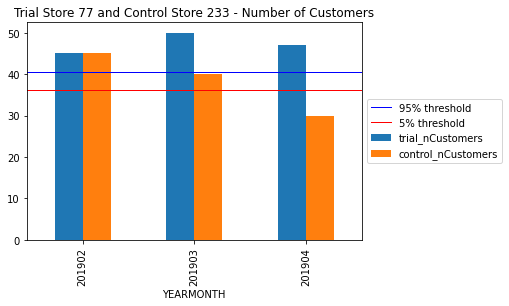

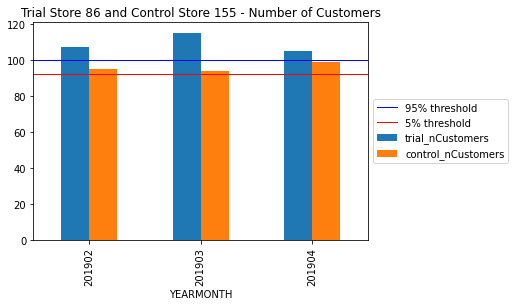

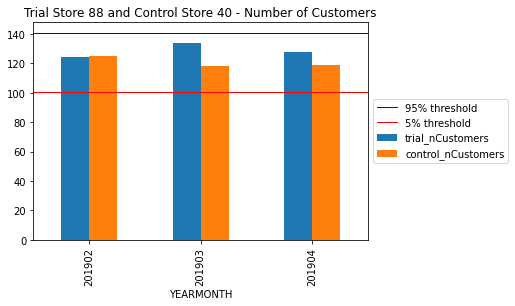

In [40]:
for trial, control in trial_control_dic.items():
    a = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control].rename(columns={"nCustomers": "control_nCustomers"})
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YEARMONTH", "nCustomers"]].rename(columns={"nCustomers": "trial_nCustomers"})
    comb = b[["YEARMONTH", "trial_nCustomers"]].merge(a[["YEARMONTH", "control_nCustomers"]],on="YEARMONTH").set_index("YEARMONTH")
    comb.plot.bar()
    cont_sc_ncust = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control]["nCustomers"]
    std = scaledncust_vs_trial[(scaledncust_vs_trial["c_STORE_NBR"] == control) & (scaledncust_vs_trial["trial_period"]=="pre")]["nCust_Percentage_Diff"].std()
    thresh95 = cont_sc_ncust.mean() + (cont_sc_ncust.mean() * std * 2)
    thresh5 = cont_sc_ncust.mean() - (cont_sc_ncust.mean() * std * 2)
    plt.axhline(y=thresh95,linewidth=1, color='b', label="95% threshold")
    plt.axhline(y=thresh5,linewidth=1, color='r', label="5% threshold")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control)+" - Number of Customers")
    plt.savefig("TS {} and CS {} - nCustomers.png".format(trial,control), bbox_inches="tight")

We can see that Trial store 77 sales for Feb, March, and April exceeds 95% threshold of control store. Same goes to store 86 sales for all 3 trial months.

1. Trial store 77: Control store 233
2. Trial store 86: Control store 155
3. Trial store 88: Control store 40
4. Both trial store 77 and 86 showed significant increase in Total Sales and Number of Customers during trial period. But not for trial store 88. Perhaps the client knows if there's anything about trial 88 that differs it from the other two trial.
5. Overall the trial showed positive significant result.